# Denoising with total variation using the PDHG method

In this notebook we denoise an image using total variation (TV) regularization and a nonnegativity constraint. We solve the minimization problem using the PDHG method.

## Contents

### Mathematics
- Problem formulation, including minimal basics on convex optimization
- The PDHG method
- Rewriting the problem in a form suitable for PDHG
  - Introducing auxiliary variables
  - Product spaces and operators

### Implementation
- Defining a space of discretized functions
- Generating a phantom and its noisy version from an image
- Defining a product space operator
- Setting up functionals
- Choosing method parameters
- Running the solver
- Checking the result

## Problem statement

We aim for solving the TV denoising problem

$$
    \min_{x \geq 0} \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 \right]
$$

for given data $y$ and some regularization parameter $\alpha > 0$. For now we do not exactly specify over which sets we optimize.

This problem is **convex** since both terms are convex, but **not differentiable** due to the 1-norm - thus, methods for smooth optimization will not work well.

Another issue with this kind of minimization problem is the presence of a linear operator $\nabla$ in the non-differentiable term. Many methods for optimizing the sum of convex functions need the **proximal operator**

$$
    \mathrm{prox}_f(x) = \mathrm{arg}\min_y \left[ f(y) + \frac{1}{2} \| x - y \|^2 \right]
$$

of all terms available in an efficiently usable way, i.e., in closed form or as an easy-to-solve optimization problem. This is, in general, not the case for $f(x) = \| \nabla x \|$ due to the composition with the gradient operator. The proximal of the (scaled) 1-norm, on the other hand, is well-known as

$$
    \mathrm{prox}_{\sigma \| \cdot \|_1}(x) = S_\sigma(x),
$$

where $S_\sigma$ is the pointwise *soft-shrinkage* operator

$$
    S_\sigma(x)(t) = 
    \begin{cases}
        x(t) + \sigma, &\text{if } x(t) < -\sigma,     \\
        0,             &\text{if } \left|x(t)\right| \leq \sigma, \\
        x(t) - \sigma, &\text{if } x(t) > \sigma.      \\
    \end{cases}
$$

Here is a visualization of the soft-shrinkage operation for $\sigma = 1$:

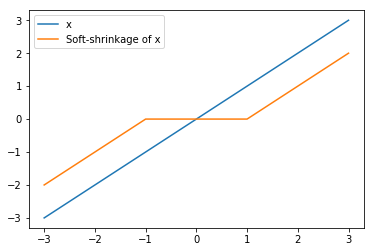

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-3, 3, 31)

def soft_shrink(x, sigma):
    res = np.zeros_like(x)
    res[x < -sigma] = x[x < -sigma] + sigma
    res[x > sigma] = x[x > sigma] - sigma
    return res


plt.plot(x, x, label='x')
plt.plot(x, soft_shrink(x, 1), label='Soft-shrinkage of x')
plt.legend()
plt.show()


## The PDHG method

The *primal-dual hybrid gradient* (PDHG) method, also known as "Chambolle-Pock method" [CP2011] is an optimization method to solve problems of the form

$$
    \min_{x \in X} \left[ f(L x) + g(x) \right]
$$

with convex functions $f$ and $g$, and a linear operator $L$. The optimum is determined in a *Hilbert space* $X$, and we have

$$
    L : X \to Y,          \\
    f : Y \to \mathbb{R}, \\
    g : X \to \mathbb{R}
$$

with some other Hilbert space $Y$. If you are not familiar with Hilbert spaces and linear operators, think $X = \mathbb{R}^n$, $Y = \mathbb{R}^m$ and $L \in \mathbb{R}^{m \times n}$.

The crucial advantage of this method over, e.g., ISTA [BT2009] is that it requires the proximals of $f$ and $g$, but **not** of the composition $f \circ L$.

## Rewriting the original problem

We now rewrite our original denoising problem in a form that is suitable for the PDHG method. There is, of course, no unique way of doing this, but we can use the method requirements as guidelines.

In particular, the proximal operators of $f$ and $g$ should be known, which means

- no composition with an operator (except for a few special cases not relevant here) and
- no sums.

We also specify the spaces now since one of the subsequent steps will require it. For convenience, we choose the **square-integrable functions** on (a subset of) $\mathbb{R}^d$, $X = L^2(\mathbb{R}^d)$. The gradient of a function $x \in X$ will be a $d$-stack of functions $\partial_i x \in X$, written as $\nabla x \in X^d$.

---
**Note:**

If you are not acquainted with these notions, think of $X = \mathbb{R}^n$. In this case, instead of function values $x(t)$ for $t \in \mathbb{R}^d$, you get discrete values $x_i,\ i=1, \dots, n$. The (discrete) gradient of an element $x \in X$ will then be a $(d \times n)$ matrix, $D x \in \mathbb{R}^{d \times n} \equiv (\mathbb{R}^n)^d$.

---

### The positivity constraint

In the original formulation, we optimize over all *pointwise nonnegative* $x$, but since that set is not a vector space, we have to use the **indicator function**

$$
    \iota_0(x)(t) =
    \begin{cases}
        0,      &\text{if } x(t) >= 0, \\
        \infty, &\text{if } x(t) < 0
    \end{cases}
$$

to rewrite the problem as a minimization over a vector space:

$$
    \min_{x \in X, x \geq 0} f(x) \quad \Leftrightarrow \quad \min_{x \in X} \left[ f(x) + \iota_0(x) \right]
$$

---
**Note:**

Sometimes we "abuse" notation by switching between writing, e.g., $\iota_0(x(t))$ and $\iota_0(x)(t)$ equivalently. 

- The first variant uses $\iota_0$ as a function $[-\infty, \infty] \to [-\infty, \infty]$ that takes in a real value $x(t)$ and produces a real value $\iota_0(x(t))$.
- The second variant takes the function $x$ as a whole and maps it to a new function $\iota_0(x)$ which evaluates to $\iota_0(x(t))$ at $t$. In that sense, $\iota_0$ is a mapping $X \to X$ for this case.

---

Revisiting our original problem formulation

$$
    \min_{x \geq 0} \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 \right]
$$

and rewriting the positivity constraint now yields

$$
    \min_x \left[ \| x - y \|_2^2 + \alpha \| \nabla x \|_1 + \iota_0(x) \right].
$$

### Splitting into $f$ and $g$

We now need to identify the $f$ and $g$ parts for the PDHG method. Remember that $f$ is allowed to be composed with linear operators, $g$ not. We will choose to take $g = \iota_0$ and put the other two terms into $f$ since later on, when we consider more general problems with a forward operator (e.g. tomography), the term $\| x - y \|_2^2$ will also contain a linear operator, $\| A x - y \|_2^2$.

### Decoupling the $f$ terms

Now we have a problem: According to the used splitting, we would get $f(x) = \| x - y \|_2^2 + \alpha \| \nabla x \|_1$. However, since we need $\mathrm{prox}_{\sigma f}$, we *cannot use sums of functions in $f$*.

Fortunately, we can use a trick to solve this issue. The computation of the functional sum can be viewed like this:

$$
    x \to \binom{z_1 = x}{z_2 = \nabla x} \to \| z_1 - y \|_2^2 + \alpha \| z_2 \|_1,
$$

i.e., by using auxiliary variables $z_1$ and $z_2$ the problem can be split into independent parts. Note that the variable $z_2$ is the gradient of an element in $X$, hence it lies in $X^d$ as explained [above](TV_denoising_with_PDHG.ipynb#Rewriting-the-original-problem).

The following procedure leads to the desired result:

1. Define a "stacked" vector $z = \binom{z_1}{z_2}$ with $z_1 \in X, z_2 \in X^d$. In other words, work in the (Cartesian) **product space** $Z = X \times X^d$. For the special case $X = \mathbb{R}^n$, this is equivalent to stacking an $\mathbb{R}^n$ vector and an $\mathbb{R}^{d \times n}$ matrix either as an $\mathbb{R}^{(d+1) \times n}$ matrix or an $\mathbb{R}^{(d+1) n}$ vector.

2. Define $f$ as a function on the product space $Z$ rather than on the space $X$, namely

   $$
       f(z) = \| z_1 - y \|_2^2 + \alpha \| z_2 \|_1 = f_1(z_1) + f_2(z_2).
   $$
   
   This sum is **separable**, meaning that there are no mixed terms, and such a separable sum has the nice property that the proximal separates along the components:
   
   $$
       \mathrm{prox}_f(z) = \binom{\mathrm{prox}_{f_1}(z_1)}{\mathrm{prox}_{f_2}(z_2)}.
   $$
   
   These proximals have closed form expressions.
   
3. Define the linear operator $L: X \to Z$ as the **broadcasting** of the identity operator $I: X \to X$ and the gradient operator $\nabla: X \to X^d$:

   $$
       L = \binom{I}{\nabla}, \quad L x = \binom{x}{\nabla x} \in Z.
   $$
   
Now it is easy to see that indeed,

$$
    f(L x) = f\binom{x}{\nabla x} = f_1(x) + f_2(\nabla x) = \|x - y\|_2^2 + \alpha\|\nabla x\|_1.
$$

---
**Note:**
This trick of introducing auxiliary variables can always be applied when sums of functions should be optimized. However, one should be aware that this procedure comes at a cost: In a numerical implementation, each variable must be stored in memory during optimization. In our case, this means that the memory usage is at least $(d+1)$ times the size of a vector $x \in X$. For large-scale 3D problems, this can be a serious issue.

---
   
### Final problem formulation

We can now put everything together and state the problem in a form suitable for the PDHG method:

- Reconstruction space $X = L^2(\mathbb{R}^d)$
- Product space $Z = X \times X^d$
- Forward operator
  $$
      L: X \to Z,\quad L = \binom{I}{\nabla}
  $$
- Function $f$ that will be composed with $L$:  
  $$
      f: Z \to \mathbb{R},\quad f(z) = \| z_1 - y \|_2^2 + \alpha \| z_2 \|_1 
  $$
- Function $g$ without linear operator:
  $$
      g: X \to \mathbb{R},\quad g = \iota_0
  $$
  
Now we finally turn to the implementation in ODL. This is derived from the [PDHG denoising example in ODL](https://github.com/odlgroup/odl/blob/master/examples/solvers/pdhg_denoising.py).

## Implementation

We will use the ["ascent" test image from SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.ascent.html) with additive white noise (since that is what $\|\cdot - y\|_2^2$ is suitable for).

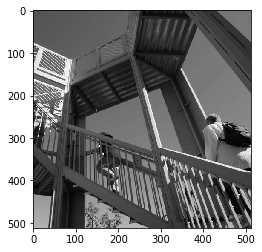

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.misc

image = scipy.misc.ascent().astype('float32')
plt.imshow(image, cmap='gray')


Now we define the reconstruction space $X$. In ODL, function spaces consist of functions defined on cuboids $Q = [a, b]$, where $a, b \in \mathbb{R}^d$ with $a \leq b$ entry-wise.
For discretization, the number $N \in \mathbb{N}^d$ of points per axis needs to be specified. This is called the *shape* of the space (as for NumPy arrays). 

Now, a continuous function $x$ is represented by its discrete values $x_i = x(t_i)$, where

$$
    t_i = t_0 + i \Delta t,\quad 0 \leq i < N,\ t_0, \Delta t \in \mathbb{R}^d,
$$

are uniform samples from the cuboid $[a, b]$ (note that addition and multiplication above are componentwise).

In two dimensions, for instance, this is a way of interpreting an image $x \in \mathbb{R}^{N_1 \times N_2}$ as a discretized function on some rectangle $[a_1, b_1] \times [a_2, b_2]$.
For our example, we choose $a = 0$ and $b = N$ to make each pixel have size $1 \times 1$.

In [3]:
import odl

# The shape we need to use is the transposed of the original shape since
# ODL uses 'xy' axes while the image is stored with 'ij' axis convention.
shape = image.T.shape

# `min_pt` corresponds to `a`, `max_pt` to `b`
X = odl.uniform_discr(min_pt=[0, 0], max_pt=shape, shape=shape)

print('Pixel size:', X.cell_sides)

Pixel size: [ 1.  1.]


 Now we make the (rescaled) image an element $x_{\mathrm{true}} \in X$ and define the noisy image $y = x_{\mathrm{true}} + 0.1 \cdot N(0, 1)$ as a space element, too.

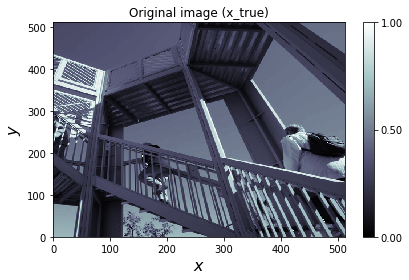

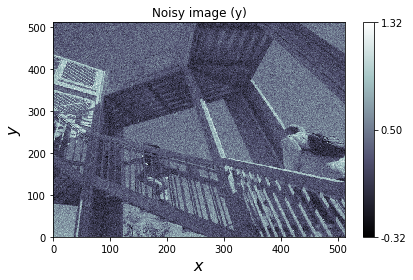

In [4]:
# The rotation converts from 'ij' to 'xy' axes
image /= image.max()
x_true = X.element(np.rot90(image, -1))
# To get predictable randomness, we explicitly seed the random number generator
with odl.util.NumpyRandomSeed(123):
    y = x_true + 0.1 * odl.phantom.white_noise(X)

# We use a semicolon at the end to avoid the figure being shown twice
x_true.show(title='Original image (x_true)');
y.show(title='Noisy image (y)');

Now we set up the parts of the problem:

- Forward operator
  $$
      L: X \to Z,\quad L = \binom{I}{\nabla}
  $$

Note that we don't have to set up the product space $Z$ explicitly since the `odl.Gradient` operator does it for us.

In [5]:
grad = odl.Gradient(X)
print('Gradient domain X:', grad.domain)
print('Gradient range X^d:', grad.range)

Gradient domain X: uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))
Gradient range X^d: (uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))) ** 2


In [6]:
I = odl.IdentityOperator(X)
L = odl.BroadcastOperator(I, grad)
print('Domain of L:', L.domain)
print('Range of L:', L.range)

Domain of L: uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))
Range of L: uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512)) x (uniform_discr([ 0.,  0.], [ 512.,  512.], (512, 512))) ** 2


- Function $f$ that will be composed with $L$:  
  $$
      f: Z \to \mathbb{R},\quad f(z) = \| z_1 - y \|_2^2 + \alpha \| z_2 \|_1 = f_1(z_1) + f_2(z_2)
  $$

In [7]:
# `.translated(y)` takes care of the `. - y` part in the function
f_1 = odl.solvers.L2NormSquared(X).translated(y)
# The regularization parameter `alpha` is multiplied with the L1 norm.
# The L1 norm must be defined on X^d, the range of the gradient.
alpha = 0.15
f_2 = alpha * odl.solvers.L1Norm(grad.range)
f = odl.solvers.SeparableSum(f_1, f_2)

# We can test whether everything makes sense by evaluating `f(L(x))`
# at some arbitrary `x` in `X`. It should produce a scalar.
print(f(L(X.zero())))

43091.268627599915


- Function $g$ without linear operator:
  $$
      g: X \to \mathbb{R},\quad g = \iota_0
  $$

In [8]:
g = odl.solvers.IndicatorNonnegativity(X)

Now we can invoke the solver with the problem components as defined above. To guarantee convergence, the step-size-like parameters $\tau$ (primal step) and $\sigma$ (dual step) need to be chosen according to the criterion

$$
    \|L\|^2 \tau \sigma < 1
$$

(For more information you can type `?? odl.solvers.pdhg` in a code cell.)

Here, $\|L\|$ is the *operator norm* of $L$, like the Frobenius norm of a matrix. Usually it's safe to estimate the norm, add a bit of safety margin and then choose

$$
    \tau = \sigma = \frac{1}{\|L\|}.
$$

Fortunately, we have a tool to estimate this norm. It uses the [Power Method](https://en.wikipedia.org/wiki/Power_iteration):

In [9]:
# We cannot start the iteration from a constant vector since the
# gradient would produce 0, which is invalid in the power iteration.
# The noisy image `y` should do.
L_norm = 1.1 * odl.power_method_opnorm(L, xstart=y, maxiter=20)

tau = 1.0 / L_norm
sigma = 1.0 / L_norm

print('||L|| =', L_norm)

||L|| = 3.21244697707


Now we're finally ready to go!

In [10]:
# Starting point
x = X.zero()

# Run PDHG method. The vector `x` is updated in-place.
odl.solvers.pdhg(x, f, g, L, tau=tau, sigma=sigma, niter=200)

We can now visually investigate the result, or we can apply quality measures (Figures of Merit, FOMs) from the `odl.contrib.fom` subpackage:

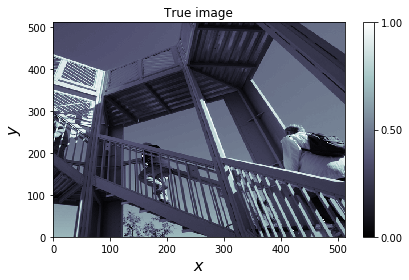

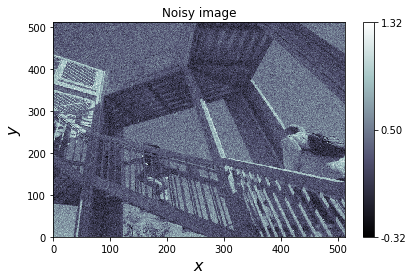

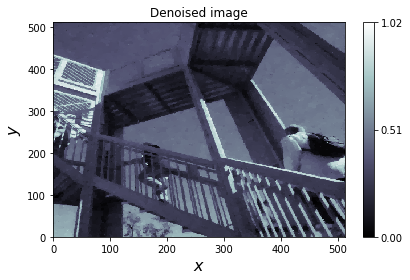

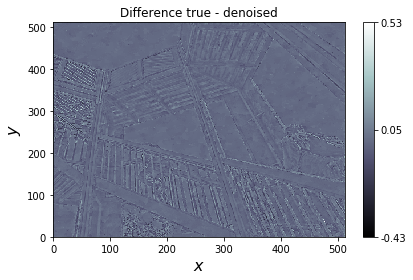

In [11]:
x_true.show('True image');
y.show('Noisy image');
x.show('Denoised image');
(x_true - x).show('Difference true - denoised');

In [12]:
from odl.contrib import fom

print('Noisy')
print('-----')
print('Mean squared error:', fom.mean_squared_error(y, x_true))
print('PSNR:', fom.psnr(y, x_true))
print('SSIM:', fom.ssim(y, x_true))
print('')

print('Denoised')
print('--------')
print('Mean squared error:', fom.mean_squared_error(x, x_true))
print('PSNR:', fom.psnr(x, x_true))
print('SSIM:', fom.ssim(x, x_true))

Noisy
-----
Mean squared error: 0.009962078152327029
PSNR: 20.0165005556
SSIM: 0.338040264996

Denoised
--------
Mean squared error: 0.0016104594735290435
PSNR: 27.9305019953
SSIM: 0.845871839388


## References

[BT2009] Beck, A and Teboulle, M. *A Fast Iterative Shrinkage-Thresholding Algorithm for Linear Inverse Problems*. SIAM Journal on Imaging Sciences, Vol. 2, No. 1 (2009), pp. 183-202.


[CP2011] Chambolle, A and Pock, T. *A First-Order Primal-Dual Algorithm for Convex Problems with Applications to Imaging*. Journal of Mathematical Imaging and Vision, 40 (2011), pp 120-145.
